<a href="https://colab.research.google.com/github/Enriquebadenas/work_in_progress/blob/main/AutoPoli_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
import os
import cv2
import imghdr
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<ipython-input-2-39b80906de60>:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [3]:
# Montar Google Drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/Colab Notebooks/AutoPoli'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Extensiones válidas de imágenes
image_exts = ['jpeg', 'jpg', 'png', 'bmp', 'gif']  # Agrega más si es necesario

# Verificar y limpiar imágenes dañadas
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)

    if os.path.isdir(class_path):  # Asegurarse de que sea un directorio
        for image in os.listdir(class_path):
            image_path = os.path.join(class_path, image)

            # Verificar que es un archivo antes de procesarlo
            if os.path.isfile(image_path):
                try:
                    img = cv2.imread(image_path)
                    tip = imghdr.what(image_path)
                    if tip not in image_exts:
                        print(f'Eliminando imagen corrupta: {image_path}')
                        os.remove(image_path)
                except Exception as e:
                    print(f'Error con imagen: {image_path}, {e}')
                    os.remove(image_path)
# Tamaño objetivo
target_size = (512, 512)  # O puedes elegir (256, 256)

# Función para redimensionar con padding
def resize_with_padding(image, target_size):
    h, w = image.shape[:2]
    target_w, target_h = target_size

    # Calcular la escala para mantener la relación de aspecto
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Redimensionar la imagen
    resized_image = cv2.resize(image, (new_w, new_h))

    # Crear una imagen en blanco de tamaño target_size
    padded_image = np.ones((target_h, target_w, 3), dtype=np.uint8) * 255  # Blanco, puedes cambiar a negro (0)

    # Pegar la imagen redimensionada en el centro
    pad_w = (target_w - new_w) // 2
    pad_h = (target_h - new_h) // 2
    padded_image[pad_h:pad_h+new_h, pad_w:pad_w+new_w] = resized_image

    return padded_image

# Redimensionar imágenes en cada clase
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            img = cv2.imread(image_path)
            img_resized_padded = resize_with_padding(img, target_size)  # Redimensionar con padding
            cv2.imwrite(image_path, img_resized_padded)  # Sobrescribir imagen redimensionada con padding

# Un poco de EDA

In [5]:
# Contar imágenes por clase
image_counts = {}
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        image_counts[class_folder] = len(os.listdir(class_path))

print("Imágenes por clase:", image_counts)

Imágenes por clase: {'Images_DF': 9, 'Images_XS': 3, 'Images_OK': 9}


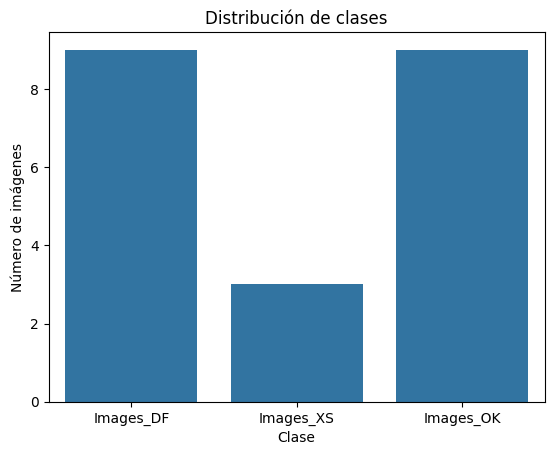

In [5]:
# Distribución de clases
class_labels = list(image_counts.keys())
class_counts = list(image_counts.values())

sns.barplot(x=class_labels, y=class_counts)
plt.title('Distribución de clases')
plt.xlabel('Clase')
plt.ylabel('Número de imágenes')
plt.show()

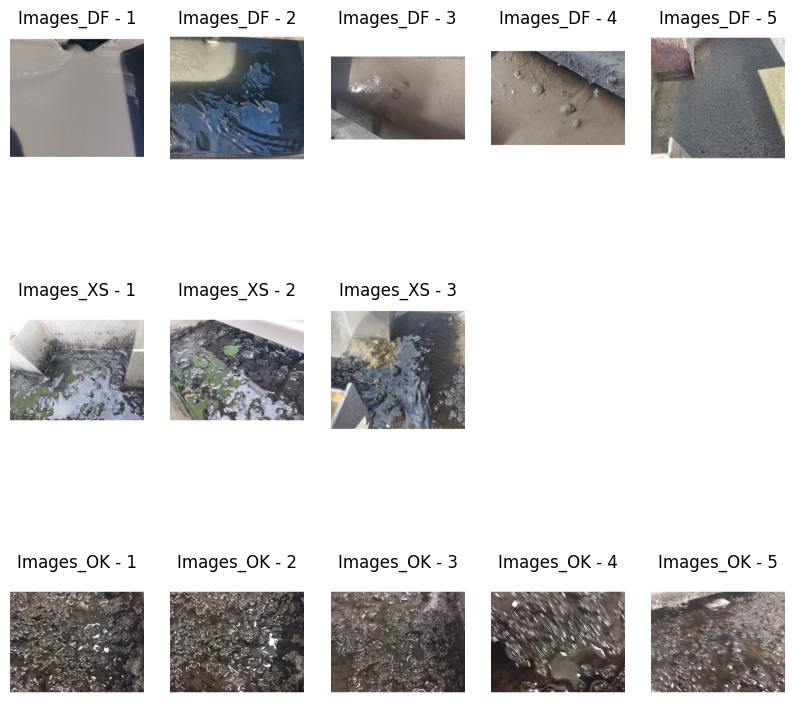

In [20]:
# Mostrar algunas imágenes de cada clase
plt.figure(figsize=(10, 10))

for idx, class_folder in enumerate(image_counts.keys()):
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        image_files = os.listdir(class_path)
        for i, image_file in enumerate(image_files[:5]):  # Muestra hasta 5 imágenes por clase
            img = cv2.imread(os.path.join(class_path, image_file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir BGR a RGB
            plt.subplot(len(image_counts), 5, idx*5 + i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'{class_folder} - {i+1}')
plt.show()

In [6]:
# Verificar tamaños de imágenes
image_sizes = {}
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            img = cv2.imread(os.path.join(class_path, image_file))
            size = img.shape  # (alto, ancho, canales)
            if size not in image_sizes:
                image_sizes[size] = 0
            image_sizes[size] += 1

print("Tamaños de imágenes:", image_sizes)


Tamaños de imágenes: {(512, 512, 3): 21}


In [7]:
# Crear el generador de datos con separación para validación
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% de las imágenes se usarán para validación
)

# Generador de entrenamiento
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Para entrenamiento
)

# Generador de validación
validation_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Para validación
)


Found 19 images belonging to 3 classes.
Found 2 images belonging to 3 classes.


In [28]:
print("Carpetas detectadas en data_dir:", os.listdir(data_dir))


Carpetas detectadas en data_dir: ['Images_DF', 'Images_XS', 'Images_OK']


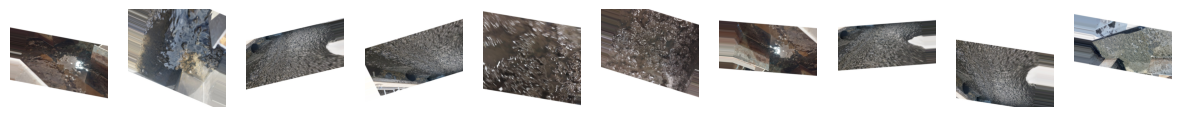

In [29]:
# Visualizar imágenes aumentadas y reales (10x10)
def show_images(generator):
    plt.figure(figsize=(15,15))
    for i in range(10):
        img, label = next(generator)  # Obtener un batch de imágenes
        plt.subplot(10, 10, i + 1)
        plt.imshow(img[0])  # Mostrar una imagen del batch
        plt.axis('off')
    plt.show()

show_images(train_gen)

In [ ]:
# MOdelo demasiado potente para pocas imágenes
# Definir un modelo de red neuronal convolucional (CNN)
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(os.listdir(data_dir)), activation='softmax')  # Número de clases
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# MOdelo SENCILLO para pocas imágenes
# Definir un modelo de red neuronal convolucional (CNN)
model = keras.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Añade Dropout para reducir sobreajuste
    layers.Dense(len(os.listdir(data_dir)), activation='softmax')
])

In [9]:
# Modelo todavía más sencillo
# Definir un modelo de red neuronal convolucional (CNN)
# Definir un modelo más simple con regularización
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(512,512,3)),
    BatchNormalization(),  # 🔹 Normaliza activaciones
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    Dropout(0.5),  # 🔹 Reduce sobreajuste
    keras.layers.Dense(3, activation='softmax')
])

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2632 - loss: 1.1347Learning rate: 9.999999747378752e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.2632 - loss: 1.1347 - val_accuracy: 0.5000 - val_loss: 1.0579
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 0.5263 - loss: 1.0832Learning rate: 9.999999747378752e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step - accuracy: 0.5263 - loss: 1.0832 - val_accuracy: 0.5000 - val_loss: 1.0349
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.5789 - loss: 1.0416Learning rate: 9.999999747378752e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step - accuracy: 0.5789 - loss: 1.0416 - val_accuracy: 0.5000 - val_loss: 1.0013
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.4211 - loss: 1.1059Learning rate: 9.999999747378752e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step - accuracy: 0.4211 - loss: 1.1059 - val_accuracy: 0.5000 - val_loss: 0.9586
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.21

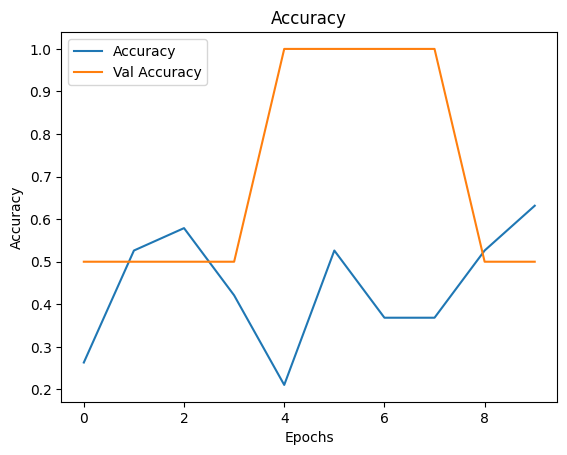

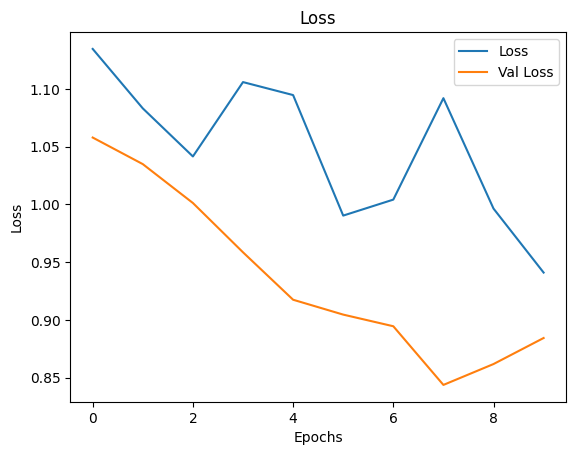

In [ ]:
# Funciona pero aparco por mejoras
# Compilar el modelo con un learning rate inicial
initial_lr = 1e-4  # Establecer manualmente el learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callback para visualizar el learning rate
def plot_lr_schedule(epoch, logs):
    lr = keras.backend.get_value(model.optimizer.learning_rate) # Changed from lr to learning_rate
    print(f"Learning rate: {lr}")

lr_callback = keras.callbacks.LambdaCallback(on_epoch_end=plot_lr_schedule)

# Entrenar el modelo con el callback y un conjunto de validación
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=validation_gen,  # ✅ Usar directamente validation_gen
    callbacks=[lr_callback]
)

# Graficar las métricas del modelo (como accuracy y loss)
def plot_history(history):
    # Graficar precisión
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Graficar pérdida
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.4211 - loss: 1.9669Learning rate: 9.999999747378752e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step - accuracy: 0.4211 - loss: 1.9669 - val_accuracy: 0.5000 - val_loss: 1.2206 - learning_rate: 1.0000e-04
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.4737 - loss: 21.8112Learning rate: 9.999999747378752e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step - accuracy: 0.4737 - loss: 21.8112 - val_accuracy: 0.5000 - val_loss: 1.1236 - learning_rate: 1.0000e-04
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.3684 - loss: 28.8922Learning rate: 9.999999747378752e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 0.3684 - loss: 28.8922 - val_accuracy: 0.5000 - val_loss: 1.5706 - learning_rate: 1.0000e-04
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.6842 - loss: 15.3854Learning rate: 9.999999747378752e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 0.6842 - loss: 15.3854 - val_accuracy: 0.5000 -

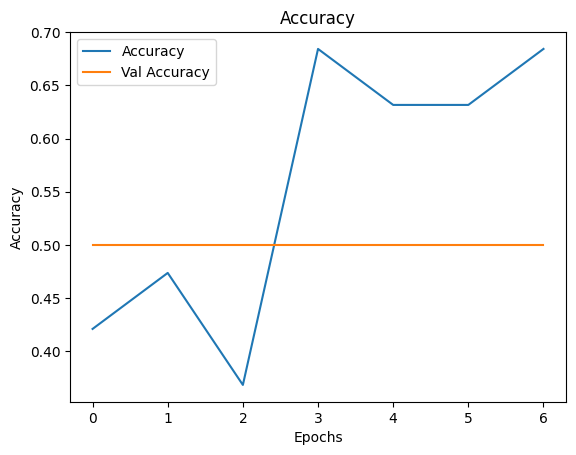

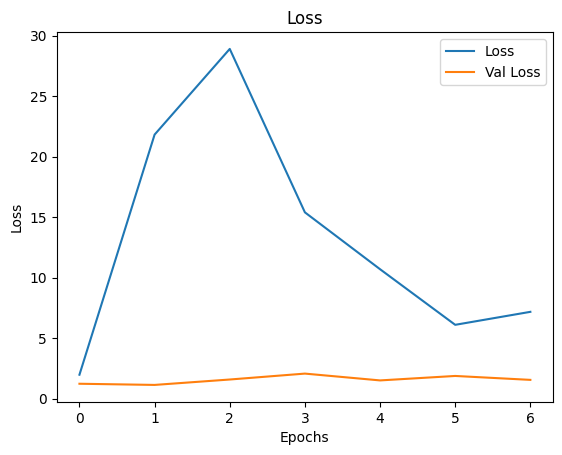

In [10]:
# Compilar el modelo con un learning rate inicial
initial_lr = 1e-4  # 🔹 Aumentar learning rate inicial
optimizer = keras.optimizers.Adam(learning_rate=initial_lr, decay=1e-5)  # 🔹 Decay para reducir lr gradualmente

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks para evitar sobreajuste y ajustar el learning rate automáticamente
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6
)

# Callback para visualizar el learning rate
def plot_lr_schedule(epoch, logs):
    lr = keras.backend.get_value(model.optimizer.learning_rate)
    print(f"Learning rate: {lr}")

lr_callback = keras.callbacks.LambdaCallback(on_epoch_end=plot_lr_schedule)

# Entrenar el modelo con el callback y un conjunto de validación
history = model.fit(
    train_gen,
    epochs=20,  # 🔹 Se aumenta a 20 porque EarlyStopping detendrá antes si es necesario
    validation_data=validation_gen,
    callbacks=[early_stopping, reduce_lr, lr_callback]  # 🔹 Se agregan los nuevos callbacks
)

# Graficar las métricas del modelo (como accuracy y loss)
def plot_history(history):
    # Graficar precisión
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Graficar pérdida
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)